Nuclei masks for images that to not have DAPI

A few of the images from this data set do not have dapi as I forgot when I was mounting. As a result I need to figure out a decent way to segment nuclei images from the other channels. 

In [4]:
import os
import numpy as np
from skimage import io
from skimage.filters import threshold_otsu, gaussian
from nd2reader import ND2Reader
from datetime import datetime
import matplotlib.pyplot as plt
import napari
from scipy.fftpack import dct

# Read in sample image
This is for reading in a .nd2 file. The original file has a total of 6 channels. There are multiple FOV's. These are also z-stacks with three colors. C1 = CEBPb-AF647. C2-AF555 = GR, C3 = VDR-AF488

In [2]:
gr_vdr_dir = r'Z:\TAD\200610_adipogenesis_timecourse_r10_v2\gr-rxr-set'
os.chdir(gr_vdr_dir)


In [3]:
nd2_multipoints = ND2Reader('stad430_rois002.nd2') # read in a vdr-gr-cebpb image that has no dapi
nd2_multipoints.bundle_axes = 'czyx' #bundle the channel and zyx coordinates
nd2_multipoints.iter_axes = 'v' # set the index to the field of view
img_5d = np.array(nd2_multipoints[:2], dtype = float) #change the pims image into a numpy array containing float

In [4]:
img_5d.shape

(2, 3, 25, 2044, 2048)

# First Pass:
As a first pass this is not doing as great of a job as I would have hoped. I am still getting a good bit of background on the CEBPb channel

on second pass it looks like it is actually the 488 image that is add all of the background

In [8]:
'''this is function to normalize 3d array. It takes in a 3d array and divides each voxel by the 98%'''
def normalize_img(img_, percentile = .98):
    normer = np.quantile(img_, percentile)
    return(np.divide(img_, normer))

In [9]:

'''this is for generating image that is the averaged mip from each channel for each fov'''
img_dict = {} #dictionary to contain the mips

img_5d_ = img_5d[:2, :, :, :, :]

for fov in range(img_5d_.shape[0]): #iterate over the fields of view
    img_4d = img_5d_[fov, :, :, :] #pull out a single filed of view. This has all three c and zyx
    img_4d = img_4d[:-1, :, :, :]
    img_4d = np.moveaxis(img_4d, 0, -1) #move the channel to the last axis
    img_4d_blurred = gaussian(img_4d, 5, multichannel = True) #apply a gaussian filter to each channel in the image
    #c1_3d = img_4d[0, :, :, :] #cebp zstack
    #c2_3d = img_4d[1, :, :, :] #gr zstack
    #c3_3d = img_4d[2, :, :, :] #vdr zstack
    #c1_3d_blurred = gaussian(c1_3d, 3) #apply a guassian filter to the image
    #c2_3d_blurred = gaussian(c2_3d, 3)
    #c3_3d_blurred = gaussian(c3_3d, 3)
    #c1_3d_normed = normalize_img(c1_3d_blurred) #normalize the blurred image
    #c2_3d_normed = normalize_img(c2_3d_blurred)
    #c3_3d_normed = normalize_img(c3_3d_blurred)
    #new_img = np.zeros((c1_3d.shape[0], c1_3d.shape[1], c1_3d.shape[2])) #this is new 3d array to be populated with maximum values
    channel_max = np.mean(img_4d_blurred, axis = -1)
    z_max = np.max(channel_max, axis = 0)
    img_dict.update({'max_img'+str(fov) : z_max})


KeyboardInterrupt: 

In [60]:
fix, axes = plt.subplots(1, 3)
axes = axes.flatten()

axes[0].imshow(img_4d[12, :, :, 0])
axes[1].imshow(img_4d[12, :, :, 1])
#axes[2].imshow(img_4d[12, :, :, 2])
axes[2].imshow(z_max)

In [32]:
z_mean = np.copy(z_max)
channel_max = np.max(img_4d_blurred, axis = -1)
z_max = np.max(channel_max, axis = 0)

In [37]:
z_mean_ = np.mean(img_4d_blurred, axis = -1)
z_mean_ = np.mean(channel_max, axis = 0)

In [39]:
z_mean_ = z_mean_.astype('float32')
io.imsave('z_mean_.tif', z_mean_)

In [36]:
io.imsave('z_mean.tif', z_mean)
io.imsave('z_max.tif', z_max)

In [35]:
z_mean = z_mean.astype('float32')
z_max = z_max.astype('float32')

In [29]:
%matplotlib qt

In [31]:
fix, axes = plt.subplots(1, 4)
axes = axes.flatten()

axes[0].imshow(img_4d[12, :, :, 0])
axes[1].imshow(img_4d[12, :, :, 1])
axes[2].imshow(img_4d[12, :, :, 2])
axes[3].imshow(z_max)

# Filter to get rid of bg in CEBPb 
I am going to do a little bit of filtering to try and get rid of the background in the cebp b channel

In [49]:
img_4d = img_5d[1, :, :, :]

In [58]:
c2_3d = img_4d[1, :, :, :]
c3_3d = img_4d[2, :, :, :]

c23_meaned = (c2_3d + c3_3d) / 2
c23_meaned = gaussian(c23_meaned, 5)
#c2_max = np.max(c2_3d, axis = 0)
#c3_max = np.max(c3_3d, axis = 0)
#c2_max_blurred = gaussian(c2_max, 5)
#c3_max_blurred = gaussian(c3_max, 5)
c23_meaned_mip = np.max(c23_meaned, axis = 0)


c23_thresh = threshold_otsu(c23_meaned_mip)
c23_mask = np.array(c23_meaned_mip > c23_thresh)

fig, axes = plt.subplots(1,3)
axes = axes.flatten()

axes[0].imshow(c2_3d[12, :, :])
axes[1].imshow(c3_3d[12, :, :])
axes[2].imshow(c23_mask)

In [53]:
c23_meaned.shape

()

In [51]:
viewer = napari.Viewer()
viewer.add_image(c2_3d)

<Image layer 'c2_3d' at 0x1fb8db5b608>

# Pull middle slice instead
This is still not working exactly as I would like but I think that much of the background can be overcome by just finding the middle slice

In [10]:
'''This will calculate and return the shannon entropy of the normalized discrete cosine transform. This is 
taken from strategy used in doi: 10.1038/nbt.3708. takes in a 2D array and spits out a scaler, the dcst.
'''
def dcts(img_):
    dis_cos = dct(img_) #take the discrete cosine transform of the image
    l2 = np.sqrt(np.sum(np.square(img_))) #perform l2 normalization
    inner_term = np.divide(dis_cos, l2) #inner term of the shannon enropy
    '''need to get rid of any zeros that occur in inner term'''
    inner_term[inner_term == 0] = .0001
    first_term = np.abs(inner_term) #first term of shannon entropy
    second_term = np.log2(np.abs(inner_term)) #second term of shannon entropy 
    return(np.multiply(-1, np.sum(np.multiply(first_term, second_term))))
    #return(second_term)

In [11]:
'''this is function to normalize 3d array. It takes in a 3d array and divides each voxel by the 98%'''
def normalize_img(img_, percentile = .98):
    normer = np.quantile(img_, percentile)
    return(np.divide(img_, normer))

In [78]:
'''this is for generating image that is the averaged mip from each channel for each fov'''
img_dict = {} #dictionary to contain the mips

img_5d_ = img_5d[:2, :, :, :, :]

for fov in range(img_5d_.shape[0]): #iterate over the fields of view
    img_4d = img_5d_[fov, :, :, :] #pull out a single filed of view. This has all three c and zyx
    
    ''' I would like to find where the middle slice is first'''
    c2_3d = img_4d[2, :, :, :] #vdr zstack
    dcts_lst = [] #dictionary to be populated with the DCTS of each slice inf c2_3d
    for zslice in range(c2_3d.shape[0]): #iterate over each slice in the z stack pull out the DCTS
        c2_ = c2_3d[zslice, :, :] #choose individual slice
        dcts_lst.append(dcts(c2_)) #append the runnining list with the value of DCTS for this slice
    mid_slice = np.argwhere(np.array(dcts_lst) == np.max(dcts_lst)) #max value of DCTS lst is the middle slice
    
    '''from there I would like to get a mip of the middle regions of the image'''
    z_bottom = int(max([0, mid_slice - 3])) # put in fail safe in case mid slice is at bottom os stack
    z_top = int(min([mid_slice + 3, c2_3d.shape[0]])) #put in fail safe in case mid slice is at top of stack
    img_4d_mid_region = img_4d[:, z_bottom:z_top, :, :] #pull out only the middle seven z-slices
    img_4d_mid_region = np.moveaxis(img_4d_mid_region, 0, -1) #move the channel to the last axis
    img_4d_blurred = gaussian(img_4d_mid_region, 5, multichannel = True) #apply a gaussian filter to each channel in the image
    '''prior to combining everything together I would like to normalize all of the channels'''
    for chan in range(img_4d_blurred.shape[-1]):
        img_4d_blurred[:, :, :, chan] = normalize_img(img_4d_blurred[:, :, :, chan])
    channel_mean = np.mean(img_4d_blurred, axis = -1) #average all three channels together
    z_max = np.max(channel_mean, axis = 0) #make a mip of all three merged channels
    img_dict.update({'max_img'+str(fov) : z_max})

In [79]:
'''make a copy of z max for a little more down stream processing.'''
z_max_3chan = np.copy(z_max)

In [18]:
'''save .tif file'''
z_max3 = z_max3.astype('float32')

io.imsave('zmax_3chan.tif', z_max3)

In [23]:
#'need to put image into XYCZT'
img_4d_temp = img_4d[:, z_bottom:z_top, :, :]


#img_4d_temp1 = np.moveaxis(img_4d_temp, 0, -1) #makes order zyxc
#img_4d_temp2 = np.moveaxis(img_4d_temp1, 0, -1) #makes order yxcz
#img_4d_temp3 = np.moveaxis(img_4d_temp2, 0, 1) #makes order xycz

io.imsave('img_c1.tif',  img_4d_temp[0, :, :, :].astype('uint16'))
io.imsave('img_c2.tif',  img_4d_temp[1, :, :, :].astype('uint16'))
io.imsave('img_c3.tif',  img_4d_temp[2, :, :, :].astype('uint16'))

C:\Users\LegantLab\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: img_c3.tif is a low contrast image
  # This is added back by InteractiveShellApp.init_path()


In [19]:
img_

In [48]:
img_4d_temp.shape

(3, 6, 2044, 2048)

In [49]:
img_4d_temp1.shape

(6, 2044, 2048, 3)

In [50]:
img_4d_temp3.shape


(2048, 2044, 3, 6)

In [80]:
'''this is same as above but exclude the cebp b channel from the mip.
It is for generating image that is the averaged mip from each channel for each fov'''
img_dict = {} #dictionary to contain the mips

img_5d_ = img_5d[:2, :, :, :, :]

for fov in range(img_5d_.shape[0]): #iterate over the fields of view
    img_4d = img_5d_[fov, :, :, :] #pull out a single filed of view. This has all three c and zyx
    
    ''' I would like to find where the middle slice is first'''
    c2_3d = img_4d[2, :, :, :] #vdr zstack
    dcts_lst = [] #dictionary to be populated with the DCTS of each slice inf c2_3d
    for zslice in range(c2_3d.shape[0]): #iterate over each slice in the z stack pull out the DCTS
        c2_ = c2_3d[zslice, :, :] #choose individual slice
        dcts_lst.append(dcts(c2_)) #append the runnining list with the value of DCTS for this slice
    mid_slice = np.argwhere(np.array(dcts_lst) == np.max(dcts_lst)) #max value of DCTS lst is the middle slice
    
    '''from there I would like to get a mip of the middle regions of the image'''
    z_bottom = int(max([0, mid_slice - 3])) # put in fail safe in case mid slice is at bottom os stack
    z_top = int(min([mid_slice + 3, c2_3d.shape[0]])) #put in fail safe in case mid slice is at top of stack
    img_4d_mid_region = img_4d[1:, z_bottom:z_top, :, :] #pull out only the middle seven z-slices. This sis the only part that is different from above 
    img_4d_mid_region = np.moveaxis(img_4d_mid_region, 0, -1) #move the channel to the last axis
    img_4d_blurred = gaussian(img_4d_mid_region, 5, multichannel = True) #apply a gaussian filter to each channel in the image
    '''prior to combining everything together I would like to normalize all of the channels'''
    for chan in range(img_4d_blurred.shape[-1]):
        img_4d_blurred[:, :, :, chan] = normalize_img(img_4d_blurred[:, :, :, chan])
    channel_mean = np.mean(img_4d_blurred, axis = -1) #average all three channels together
    z_max_ = np.max(channel_mean, axis = 0) #make a mip of two merged channels
    img_dict.update({'max_img'+str(fov) : z_max_})

In [81]:
'''make a copy of z_max_ for some comparison with the 3 channel version of the same thing'''
z_max_2chan = np.copy(z_max_)

In [43]:
z_max2 = z_max2.astype('float32')

io.imsave('z_max_2chan2.tif', z_max2)

In [28]:
c2_3d.shape

(1, 25, 2044, 2048)

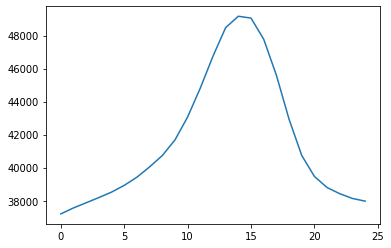

In [30]:
plt.plot(list(range(len(dcts_lst))), dcts_lst)

In [40]:
c1_3d = img_4d[0, :, :, :].astype('uint16')
c2_3d = img_4d[1, :, :, :].astype('uint16')
c3_3d = img_4d[2, :, :, :].astype('uint16')

io.imsave('c1.tif', c1_3d)
io.imsave('c2.tif', c2_3d)
io.imsave('c3.tif', c3_3d)

C:\Users\LegantLab\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: c3.tif is a low contrast image
  import sys


In [82]:
'''this is same as above but exclude the cebp b and only use the middle slice not a mip'''

img_dict = {} #dictionary to contain the mips

img_5d_ = img_5d[:2, :, :, :, :]

for fov in range(img_5d_.shape[0]): #iterate over the fields of view
    img_4d = img_5d_[fov, :, :, :] #pull out a single filed of view. This has all three c and zyx
    
    ''' I would like to find where the middle slice is first'''
    c2_3d = img_4d[1, :, :, :] #vdr zstack
    
    dcts_lst = [] #dictionary to be populated with the DCTS of each slice inf c2_3d
    for zslice in range(c2_3d.shape[0]): #iterate over each slice in the z stack pull out the DCTS
        c2_ = c2_3d[zslice, :, :] #choose individual slice
        dcts_lst.append(dcts(c2_)) #append the runnining list with the value of DCTS for this slice
    mid_slice = int(np.argwhere(np.array(dcts_lst) == np.max(dcts_lst))) #max value of DCTS lst is the middle slice
    
    '''from there I would like to get a mip of the middle regions of the image'''
    #z_bottom = int(max([0, mid_slice - 3])) # put in fail safe in case mid slice is at bottom os stack
    #z_top = int(min([mid_slice + 3, c2_3d.shape[0]])) #put in fail safe in case mid slice is at top of stack
    img_4d = np.moveaxis(img_4d, 0, -1) #move the channel to the last axis
    img_4d_mid_region = img_4d[mid_slice, :, :, :] #pull out only the middle seven z-slices. This sis the only part that is different from above 
    img_4d_mid_region = img_4d_mid_region[:, :, 1:]
    img_4d_blurred = gaussian(img_4d_mid_region, 5, multichannel = True) #apply a gaussian filter to each channel in the image
    '''prior to combining everything together I would like to normalize all of the channels'''
    for chan in range(img_4d_blurred.shape[-1]):
        img_4d_blurred[:, :, chan] = normalize_img(img_4d_blurred[:, :, chan])
    channel_mean = np.mean(img_4d_blurred, axis = -1) #average two channels together
    #z_max_ = np.max(channel_mean, axis = 0) #make a mip of two merged channels
    img_dict.update({'max_img'+str(fov) : channel_mean})

In [74]:
img_4d[mid_slice, :, :, :].shape

(2044, 2048, 3)

In [87]:
io.imsave('mid_slice_2chan.tif', channel_mean.astype('float32') )

In [85]:
%matplotlib qt

In [86]:
fig, axes = plt.subplots(1,3)
axes = axes.flatten()

axes[0].imshow(z_max_3chan)
axes[1].imshow(z_max_2chan)
axes[2].imshow(channel_mean)

# The winning script!

It seems like the best version of this script averages all three channels and uses middle slice

In [94]:
'''this is same as above but exclude the cebp b and only use the middle slice not a mip'''

img_dict = {} #dictionary to contain the mips

img_5d_ = img_5d[:2, :, :, :, :]

for fov in range(img_5d_.shape[0]): #iterate over the fields of view
    img_4d = img_5d_[fov, :, :, :] #pull out a single filed of view. This has all three c and zyx
    
    ''' I would like to find where the middle slice is first'''
    c2_3d = img_4d[1, :, :, :] #vdr zstack
    
    dcts_lst = [] #dictionary to be populated with the DCTS of each slice inf c2_3d
    for zslice in range(c2_3d.shape[0]): #iterate over each slice in the z stack pull out the DCTS
        c2_ = c2_3d[zslice, :, :] #choose individual slice
        dcts_lst.append(dcts(c2_)) #append the runnining list with the value of DCTS for this slice
    mid_slice = int(np.argwhere(np.array(dcts_lst) == np.max(dcts_lst))) #max value of DCTS lst is the middle slice
    
    '''from there I would like to get a mip of the middle regions of the image'''
    #z_bottom = int(max([0, mid_slice - 3])) # put in fail safe in case mid slice is at bottom os stack
    #z_top = int(min([mid_slice + 3, c2_3d.shape[0]])) #put in fail safe in case mid slice is at top of stack
    img_4d = np.moveaxis(img_4d, 0, -1) #move the channel to the last axis
    img_4d_mid_region = img_4d[mid_slice, :, :, :] #pull out only the middle seven z-slices. This sis the only part that is different from above 
    #img_4d_mid_region = img_4d_mid_region[:, :, 1:]
    img_4d_blurred = gaussian(img_4d_mid_region, 7, multichannel = True) #apply a gaussian filter to each channel in the image
    '''prior to combining everything together I would like to normalize all of the channels'''
    for chan in range(img_4d_blurred.shape[-1]):
        img_4d_blurred[:, :, chan] = normalize_img(img_4d_blurred[:, :, chan])
    channel_mean = np.mean(img_4d_blurred, axis = -1) #average two channels together
    #z_max_ = np.max(channel_mean, axis = 0) #make a mip of two merged channels
    img_dict.update({'max_img'+str(fov) : channel_mean})

In [95]:
mid_3chan_s7 = np.copy(channel_mean)
mid_2chan = io.imread('mid_slice_2chan.tif')

In [96]:
fig, axes = plt.subplots(1,3)
axes = axes.flatten()

axes[0].imshow(mid_2chan)
axes[1].imshow(mid_3chan)
axes[2].imshow(mid_3chan_s7)

In [92]:
np.sum(mid_2chan != mid_3chan)

4186112

In [36]:
#''this is from when I was thinking about trying to keep everything lazily loaded. After working on this for a little bit I realized that this is not worth
#the effort'''
#for fov in nd2_multipoints:
#    new_img = np.zeros([nd2_multipoints.sizes['z'], nd2_multipoints.sizes['y'], nd2_multipoints.sizes['x']]) #create empty array to be populated with max from each channel
#    fov_zidx = fov.iter_axes = 'z' # change index to z for iteration
#    for zidx in fov_zidx: # iterate over the z axis of the multidimiensional image. Still all three channels
#        fov_yidx = zidx.iter_axes = 'y' #change index over to y for iteration
#        for yidx in fov_yidx: #iterate over the y
#            fov_xidx = yidx.iter_axes = 'x' #
#            for xidx in fov_xidx:
#                
#                new_img[zidx, yidx, xidx] = max([fov_xidx[0], fov_xidx[1], fov_xidx[2]])

'this is from when I was thinking about trying to keep everything lazily loaded. After working on this for a little bit I realized that this is not worth\nthe effort'

In [26]:
new_img = np.zeros([nd2_multipoints.sizes['z'], nd2_multipoints.sizes['y'], nd2_multipoints.sizes['x']])

In [27]:
new_img.shape

(25, 2044, 2048)

In [34]:
'''just a little random speed test'''
import datetime

In [36]:
np.random.seed(42)
test_mat = np.random.randint(0, 100, (5000, 5000))

In [37]:
test_mat

array([[51, 92, 14, ..., 38, 79, 96],
       [84, 60,  8, ..., 79, 18,  7],
       [37, 37, 52, ..., 46, 80, 29],
       ...,
       [63, 26, 37, ..., 47, 23, 95],
       [52, 81, 41, ...,  9, 25, 91],
       [64, 43, 22, ..., 54, 53, 20]])

In [38]:
start = datetime.datetime.now()
np.linalg.inv(test_mat)
print(datetime.datetime.now() - start)

0:00:11.080464


# This is a trying to figure out why DCTS is not working in another script

In [5]:
os.chdir(r'Y:\TAD\200610_adipogenesis_timecourse_r10_v2\gr-rxr-set')
nd2_multipoints = ND2Reader('stad425_rois004.nd2') # read in a vdr-gr-cebpb image that has no dapi
nd2_multipoints.bundle_axes = 'czyx' #bundle the channel and zyx coordinates
nd2_multipoints.iter_axes = 'v' # set the index to the field of view
img_5d = np.array(nd2_multipoints[:2], dtype = float) #change the pims image into a numpy array containing float

In [12]:
for fov in range(img_5d.shape[0]): #iterate over the fields of view
    img_4d = img_5d[fov, :, :, :] #pull out a single filed of view. This has all three c and zyx
    
    ''' I would like to find where the middle slice is first'''
    c2_3d = img_4d[2, :, :, :] #vdr zstack
    dcts_lst = [] #dictionary to be populated with the DCTS of each slice inf c2_3d
    for zslice in range(c2_3d.shape[0]): #iterate over each slice in the z stack pull out the DCTS
        c2_ = c2_3d[zslice, :, :] #choose individual slice
        dcts_lst.append(dcts(c2_)) #append the runnining list with the value of DCTS for this slice
    mid_slice = np.argwhere(np.array(dcts_lst) == np.max(dcts_lst)) #max value of DCTS lst is the middle slice

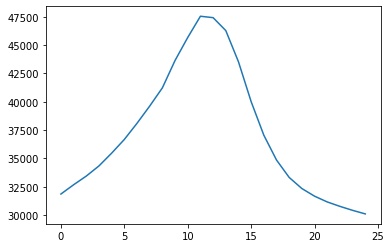

In [13]:
plt.plot(list(range(len(dcts_lst))), dcts_lst)

In [15]:
io.imsave('old.tif', c2_3d.astype('float32'))